# PolynomialFitting

Learn to fit polynomials through RandomForests.

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab 
import statsmodels.api as sm
import os

In [2]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print('\nForest RMSE = {:.3f} ± {:.3f}'.format(scores.mean(), scores.std()))

# Get the Data

In [3]:
x = np.linspace(0, 10, 1001)
linear_m = 10.
linear_c = 3.
linear_y = x*linear_m + linear_c

linear = pd.DataFrame({'x': x, 'y': linear_y})

In [4]:
linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
x    1001 non-null float64
y    1001 non-null float64
dtypes: float64(2)
memory usage: 15.7 KB


In [5]:
linear.describe()

,x,y
count,1001.000000,1001.000000
mean,5.000000,53.000000
std,2.891081,28.910811
min,0.000000,3.000000
25%,2.500000,28.000000
50%,5.000000,53.000000
75%,7.500000,78.000000
max,10.000000,103.000000


In [6]:
linear.head(5)

,x,y
0,0.00,3.0
1,0.01,3.1
2,0.02,3.2
3,0.03,3.3
4,0.04,3.4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C104337860>,
      dtype=object)

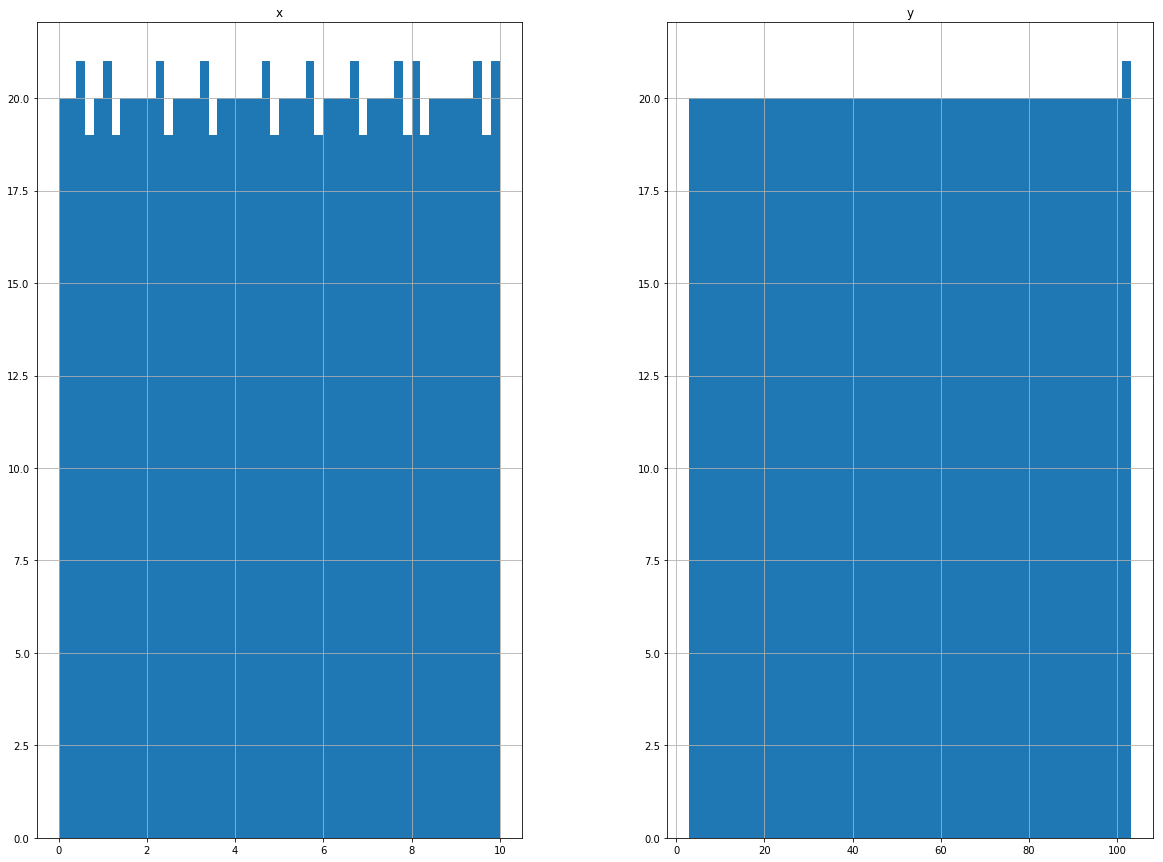

In [7]:
linear.hist(bins=50, figsize=(20,15))

## Test and training sets

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(linear, test_size=0.25, random_state=42)

y = train_set.y.values
X_train = train_set.x.values

## RandomForest model

### Train

In [15]:
X_train = X_train.reshape(-1, 1)

In [16]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=1000, random_state=42)
forest_reg.fit(X_train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Measure performance

#### RMSE

In [17]:
from sklearn.metrics import mean_squared_error
forest_preds = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y, forest_preds)
forest_rmse = np.sqrt(forest_mse)
print('Forest RMSE = {:.3f}'.format(forest_rmse))

Forest RMSE = 0.000


In [75]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, X_train, y,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

scores = cross_val_score(forest_reg, X_train, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [76]:
display_scores(tree_rmse_scores)

Scores: [0.07066127 0.07922311 0.06628923 0.07119285 0.09105676 0.07249132
 0.06144885 0.09674297 0.07394124 0.0629797 ]
Mean: 0.0746027299848691
Standard deviation: 0.010915881342231034

Forest RMSE = 0.075 ± 0.011


### Mean absolute percentage error

In [77]:
errors = abs(forest_preds - y)
mape = 100 * (errors / y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 99.92 %.


### Feature importance

In [78]:
importances = list(forest_reg.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(linear, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]; 

Variable: x                    Importance: 1.0


### Realised vs prediction

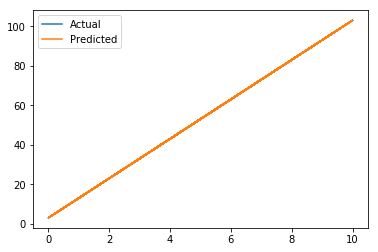

In [79]:
fig = plt.figure()
plt.plot(X_train, y, label='Actual')
plt.plot(X_train, forest_preds, label='Predicted')
plt.legend()

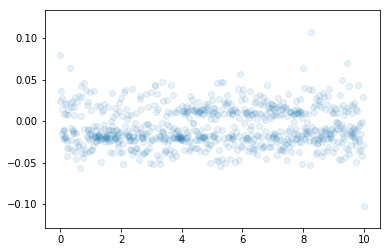

In [80]:
residuals = forest_preds - y
plt.scatter(X_train, residuals, alpha=0.1)

## Optimised RandomForest

In [81]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [1000]},
              ]
forest_reg_model = RandomForestRegressor()
n_jobs=6
grid_search = GridSearchCV(forest_reg_model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=n_jobs)
grid_search.fit(X_train, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid=[{'n_estimators': [1000]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [82]:
grid_search.best_params_

{'n_estimators': 1000}

## Linear regression

### Ridge

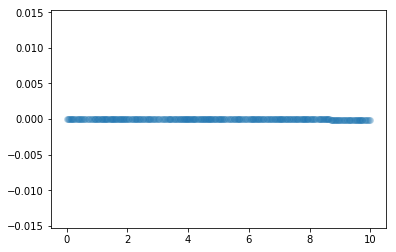

In [83]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.01, solver="cholesky", random_state=42)
ridge_reg.fit(X_train, y)

ridge_preds = ridge_reg.predict(X_train)
ridge_residuals = ridge_preds - y
plt.scatter(X_train, ridge_residuals, alpha=0.1)

### Ridge SGD

In [84]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(X_train, y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

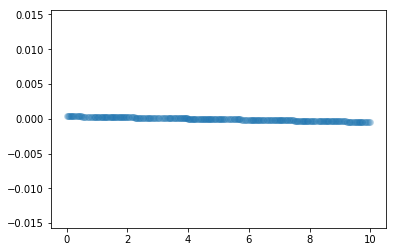

In [85]:
sgd_preds = sgd_reg.predict(X_train)
sgd_residuals = sgd_preds - y
plt.scatter(X_train, sgd_residuals, alpha=0.1)

### Lasso

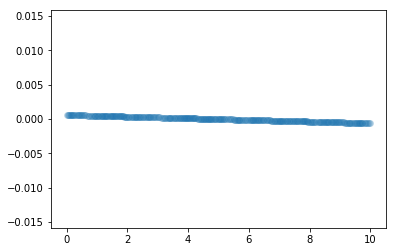

In [86]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y)

lasso_preds = lasso_reg.predict(X_train)
lasso_residuals = lasso_preds - y
plt.scatter(X_train, lasso_residuals, alpha=0.1)

### SVM

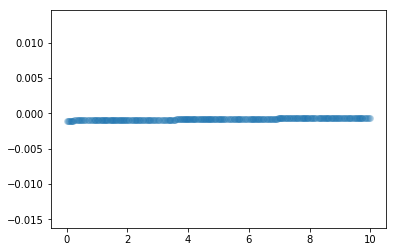

In [87]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=0.001)
svm_reg.fit(X_train, y)

svm_preds = svm_reg.predict(X_train)
svm_residuals = svm_preds - y
plt.scatter(X_train, svm_residuals, alpha=0.1)

## Out of training space projections

The linear regression models above are less able to model complex behaviors however can better project to regions outside of the training space.

## RandomForest

Extrapolates poorly, perhaps due to a weak constraint on the effective gradient of the line.

In [90]:
x = np.linspace(10, 20, 1001)
X = x.reshape(-1, 1)
y = x*linear_m + linear_c

In [91]:
forest_preds = forest_reg.predict(X)
forest_mse = mean_squared_error(y, forest_preds)
forest_rmse = np.sqrt(forest_mse)
print('Forest RMSE = {:.3f}'.format(forest_rmse))

Forest RMSE = 57.839


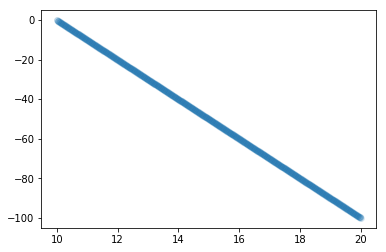

In [94]:
forest_residuals = forest_preds - y
plt.scatter(X, forest_residuals, alpha=0.1)

## SVM

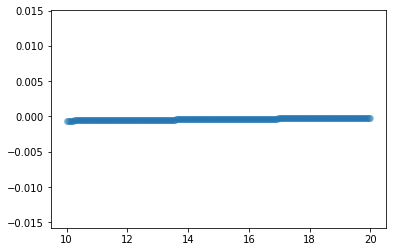

In [96]:
svm_preds = svm_reg.predict(X)
svm_residuals = svm_preds - y
plt.scatter(X, svm_residuals, alpha=0.1)